In [38]:
import pystac_client
import planetary_computer as pc

import rasterio
import rioxarray as rioxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os

from shapely.geometry import shape

## Access NAIP image collection in Planetary Computer
Adapted from sample notebook in Planetary Computer NAIP example code

In [39]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

In [40]:
# Bounding box around Campus Point
# created using https://boundingbox.klokantech.com
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [-119.8610195981,34.3938837903],
        [-119.8306927339,34.3938837903],
        [-119.8306927339,34.420119945],
        [-119.8610195981,34.420119945],
        [-119.8610195981,34.3938837903]
    ]],
}
# Temporal range of interest
date_range = "2015-01-01/2016-12-31"

# look in NAIP catalog for items on specified date and geographic range
search = catalog.search(
    collections=["naip"], 
    intersects=area_of_interest, 
    datetime=date_range
)

items = list(search.get_items())
print(f"{len(items)} Items found in the 'new' range")

1 Items found in the 'new' range


In [41]:
# choose the item that has the most overlap:
area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area

item = sorted(items, key=area_of_overlap, reverse=True)[0]
print(type(item))
item

<class 'pystac.item.Item'>


<Item id=ca_m_3411934_sw_11_.6_20160713_20161004>

In [42]:
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
print(type(ds))

<class 'rasterio.io.DatasetReader'>


In [55]:
# Explore opened dataset
print('type: ', type(ds))
print('mode: ', ds.mode)
print('# bands: ', ds.count, '\n')

print('collection date:', item.datetime, '\n')
      
print('height: ',ds.height)
print('width: ', ds.width, '\n')
      
print('CRS: ', ds.crs)      
print('spatial bounding box: ')
print(ds.bounds)
print('affine transform: ')
print(ds.transform)   # see also get_transform() and read_transform()
print('resolution:', ds.res)

type:  <class 'rasterio.io.DatasetReader'>
mode:  r
# bands:  4 

collection date: 2016-07-13 00:00:00+00:00 

height:  12340
width:  10420 

CRS:  EPSG:26911
spatial bounding box: 
BoundingBox(left=235476.0, bottom=3807168.0, right=241728.0, top=3814572.0)
affine transform: 
| 0.60, 0.00, 235476.00|
| 0.00,-0.60, 3814572.00|
| 0.00, 0.00, 1.00|
resolution: (0.6, 0.6)


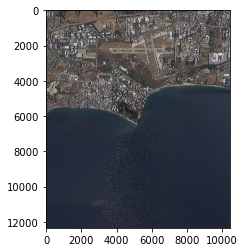

In [44]:
# check image
# some re-arranging of the order of the bands needs to be doe to fd it into .imshow
plt.imshow(np.moveaxis(ds.read(indexes=[1,2,3]),0,-1)) 

In [ ]:
# reduce_box = {
#     "type": "Polygon",
#     "coordinates":[[[-119.706701282,34.4111229027],
#                     [-119.6914677414,34.4111229027],
#                     [-119.6914677414,34.4281372721],
#                     [-119.706701282,34.4281372721],
#                     [-119.706701282,34.4111229027]]],
# }

# reduce_shape = shape(reduce_box)

# reduce = gpd.GeoDataFrame()
# reduce.loc[0,'geometry']  = reduce_shape
# reduce = reduce.set_crs("EPSG:4326")
# # MATCH CRES WITH RASTERS
# reduce = reduce.to_crs(ds.crs)



In [18]:
# red = ds.read(1)
# red_small = red.rio.clip_box(*reduce.total_bounds)
# print('original shape: ', red.shape)
# print('reduced shape: ', red_small.shape)
# red_small.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

## Open GBIF 2016 data

In [24]:
geo_obs = gpd.GeoDataFrame(
    obs,
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= obs.decimallongitude,
        y= obs.decimallatitude)
)
geo_obs.head()

,kingdom,family,genus,class,species,stateprovince,eventdate,year,month,day,decimallatitude,decimallongitude,institutioncode,geometry
1292287,Plantae,Aizoaceae,Carpobrotus,Magnoliopsida,Carpobrotus edulis,California,2016-02-11T00:00:00,2016.0,2.0,11.0,38.124518,-122.954118,iNaturalist,POINT (-122.95412 38.12452)
124774,Plantae,Aizoaceae,Carpobrotus,Magnoliopsida,Carpobrotus edulis,California,2016-11-26T15:40:00,2016.0,11.0,26.0,38.303168,-123.063569,iNaturalist,POINT (-123.06357 38.30317)
26670,Plantae,Aizoaceae,Carpobrotus,Magnoliopsida,Carpobrotus edulis,California,2016-02-20T14:42:00,2016.0,2.0,20.0,38.027594,-122.961197,iNaturalist,POINT (-122.96120 38.02759)
91682,Plantae,Aizoaceae,Carpobrotus,Magnoliopsida,Carpobrotus edulis,California,2016-03-19T11:40:35,2016.0,3.0,19.0,37.802400,-122.446528,iNaturalist,POINT (-122.44653 37.80240)
70517,Plantae,Aizoaceae,Carpobrotus,Magnoliopsida,Carpobrotus edulis,California,2016-05-11T13:41:16,2016.0,5.0,11.0,37.719444,-122.489166,iNaturalist,POINT (-122.48917 37.71944)


In [25]:
fp = os.getcwd() + '/geo_obs2016.shp'
geo_obs.to_file(fp)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_805/1576483224.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  geo_obs.to_file(fp)
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()

## Inspect iNaturalist 2018 ice plant data

In [12]:
fp = os.getcwd() +'/observations-220884.csv'
obs = gpd.GeoDataFrame(
    pd.read_csv(fp), 
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= pd.read_csv(fp).longitude, 
        y= pd.read_csv(fp).latitude)
)

In [9]:
obs.positional_accuracy
# Remove those above certain threshold for accuracy?

0        NaN
1        8.0
2        5.0
3        5.0
4        5.0
5        NaN
6        5.0
7       10.0
8       10.0
9       10.0
10       5.0
11      10.0
12      10.0
13    4527.0
Name: positional_accuracy, dtype: float64

In [10]:
coords = obs[['geometry']]
coords = coords.to_crs(ds.crs)
coords['xy'] = coords.geometry.apply(lambda p: (p.x,p.y))
coords
#coords

,geometry,xy
0,POINT (267975.733 3808626.887),"(267975.73328417906, 3808626.886953532)"
1,POINT (238399.666 3810854.686),"(238399.66635965343, 3810854.6858756235)"
2,POINT (238161.595 3810936.091),"(238161.59452229345, 3810936.090928188)"
3,POINT (238396.613 3810861.015),"(238396.61338852625, 3810861.014677771)"
4,POINT (238156.566 3810942.123),"(238156.56556926286, 3810942.1228833455)"
5,POINT (238168.362 3810934.317),"(238168.36243180145, 3810934.317332327)"
6,POINT (238402.912 3810859.251),"(238402.91166871192, 3810859.2511430746)"
7,POINT (254847.579 3811631.283),"(254847.57949129806, 3811631.282619651)"
8,POINT (254545.729 3811605.170),"(254545.7286688104, 3811605.1695517134)"
9,POINT (256842.634 3811591.667),"(256842.6335378319, 3811591.667249088)"


<AxesSubplot:>

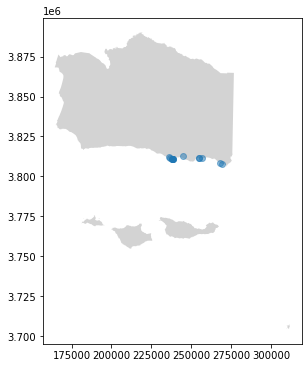

In [13]:
# ---- OPEN SB shapefile ----

sb_shape_path = "/home/jovyan/msai4earth-esa/shapefiles_n_rasters/SB_geometry/SB_only.shp"
sb_shape = gpd.read_file(sb_shape_path)
sb_shape = sb_shape.to_crs(ds.crs)

fig, ax = plt.subplots(figsize = (6,6))
sb_shape.plot(ax=ax, color='lightgrey')
coords.plot(ax=ax, alpha=0.5)

## Sample NAIP image data at observation coords

To extract information about the NAIP image we will use the dataset method `sample()` from `ds`, which is a `rasterio.io.DatasetReader`. This method will return an iterable object, remember this can omly be iterated through once.

See more at:
https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html

Because not all coordinates will be within the NAIP image, some of the samples will be [0,0,0,0]. We need to discard those.

In [46]:
sample = ds.sample(coords.xy)

data = []
for i in sample:
    if (i!= [0,0,0,0]).all():
        data.append(i)
data = np.vstack(data)
data = pd.DataFrame(data, columns=['r','g','b','nifr'])
data

,r,g,b,nifr
0,40,50,65,59
1,82,86,89,141
2,172,166,154,168
3,127,121,119,135
4,102,97,96,137
5,178,176,164,162
6,156,159,138,185
7,83,79,81,127


## Opening polygons extracted from QGIS

In [10]:
fp = os.getcwd() + '/polygons_2016/trial.shp'
trial = gpd.read_file(fp)
trial

,id,geometry
0,0,"POLYGON ((-119.84689 34.40631, -119.84356 34.4..."
1,1,"POLYGON ((-119.84710 34.41094, -119.84223 34.4..."
2,2,"POLYGON ((-119.86752 34.41834, -119.85331 34.4..."


In [5]:
print(trial['geometry'][0])

POLYGON ((-119.8468887552101 34.40631400745776, -119.84356200866763 34.40633579107665, -119.84419567467569 34.404854492070015, -119.8468887552101 34.40631400745776))


In [20]:
trial.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
trial.to_crs(ds.crs)

NameError: name 'ds' is not defined

<AxesSubplot:>

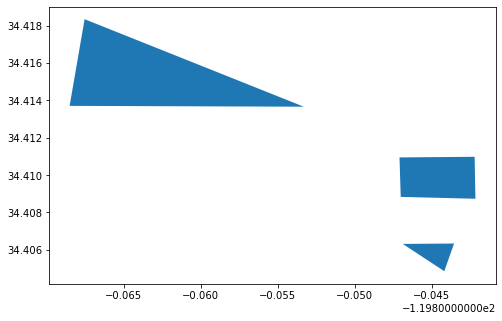

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial.plot(ax=ax)

In [31]:
from shapely.geometry import Point
import random

######
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  
######

In [35]:
i=2
points = random_points_in_polygon(100,trial['geometry'][i])
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points

<AxesSubplot:>

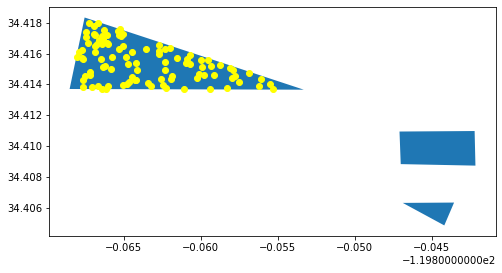

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial.plot(ax=ax)
geo_points.plot(ax=ax, color="yellow")

In [27]:
geo_points

,geometry
0,POINT (-119.84389 34.40598)
1,POINT (-119.84591 34.40611)
2,POINT (-119.84434 34.40631)
3,POINT (-119.84478 34.40609)
4,POINT (-119.84456 34.40594)
5,POINT (-119.84441 34.40619)
6,POINT (-119.84457 34.40632)
7,POINT (-119.84464 34.40590)
8,POINT (-119.84556 34.40596)
9,POINT (-119.84665 34.40625)
